In [26]:
# --- CELL 1: ROBUST DATA PROCESSING (Clean & Fill NaNs) ---
import pandas as pd
import numpy as np
import torch
import os

SAVE_DIR = "traffic_data"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

def process_uploaded_data(window_size=100, train_ratio=0.8):
    csv_path = "V_228.csv"

    if not os.path.exists(csv_path):
        print("❌ Error: 'V_228.csv' not found! Please upload it.")
        return

    print(f"🚛 Reading {csv_path}...")
    df = pd.read_csv(csv_path, header=None)

    # --- FIX 1: FILL MISSING VALUES ---
    # Real sensors fail. We fill gaps with the previous known value.
    if df.isnull().values.any():
        print(f"⚠️ Found {df.isnull().sum().sum()} missing values. Filling them...")
        df = df.fillna(method='ffill').fillna(method='bfill') # Fill forward, then backward

    raw_data = df.values

    # --- FIX 2: ROBUST NORMALIZATION (Z-Score) ---
    # Min-Max is risky if there are outliers (e.g., sensor reads 9999 mph)
    # We use Z-Score (Mean/Std) which is safer for Physics models.
    mean = np.mean(raw_data)
    std = np.std(raw_data)
    data_norm = (raw_data - mean) / (std + 1e-5) # +1e-5 prevents divide by zero

    print(f"   Data Stats | Mean: {mean:.2f}, Std: {std:.2f}")

    sequences = []
    L = len(data_norm)

    print("   Slicing data into sequences...")
    for i in range(0, L - window_size, 20):
        seq = data_norm[i : i + window_size, :]
        sequences.append(seq)

    sequences = np.array(sequences)

    n_train = int(len(sequences) * train_ratio)
    train_data = sequences[:n_train]
    test_data = sequences[n_train:]

    np.save(f"{SAVE_DIR}/train_traffic.npy", train_data)
    np.save(f"{SAVE_DIR}/test_traffic.npy", test_data)

    # Save statistics for un-normalizing later
    np.save(f"{SAVE_DIR}/stats.npy", np.array([mean, std]))

    print(f"✅ Cleaned Data Saved. Train Shape: {train_data.shape}")

process_uploaded_data(window_size=100)

❌ Error: 'V_228.csv' not found! Please upload it.


In [27]:
# --- CELL 2: STABLE TRAINING (No AMP + Gradient Clipping) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math
import os

DATA_PATH = "traffic_data/train_traffic.npy"
CHECKPOINT_DIR = "checkpoints"
EPOCHS = 30
LR = 1e-4 # Low learning rate for safety
TIMESTEPS = 300
BATCH_SIZE = 64
SENSOR_COUNT = 228
PAD_SIZE = 256

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. LOAD DATA
print("📂 Loading Cleaned Traffic Data...")
data_numpy = np.load(DATA_PATH)

# Check for NaNs one last time
if np.isnan(data_numpy).any():
    print("❌ CRITICAL: Data still contains NaNs! Check CSV file.")
else:
    print("✅ Data is clean.")

N, T, S = data_numpy.shape
X_raw = torch.FloatTensor(data_numpy[:, :-1, :])
Y_raw = torch.FloatTensor(data_numpy[:, 1:, :])

X_pad = F.pad(X_raw, (0, PAD_SIZE - SENSOR_COUNT))
Y_pad = F.pad(Y_raw, (0, PAD_SIZE - SENSOR_COUNT))

X = X_pad.reshape(-1, 1, PAD_SIZE)
Y = Y_pad.reshape(-1, 1, PAD_SIZE)

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# 2. MODEL
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ConditionalUNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Sequential(nn.Conv1d(2, 64, 3, padding=1), nn.ReLU())
        self.down2 = nn.Sequential(nn.Conv1d(64, 128, 3, padding=1), nn.ReLU())
        self.time_mlp = nn.Sequential(SinusoidalPositionEmbeddings(128), nn.Linear(128, 128), nn.ReLU())
        self.up1 = nn.Sequential(nn.Conv1d(128, 64, 3, padding=1), nn.ReLU())
        self.out = nn.Conv1d(64, 1, 1)

    def forward(self, x, t, condition):
        x_input = torch.cat([x, condition], dim=1)
        t_emb = self.time_mlp(t).unsqueeze(-1)
        d1 = self.down1(x_input)
        d2 = self.down2(d1)
        d2 = d2 + t_emb
        u1 = self.up1(d2)
        return self.out(u1 + d1)

# 3. TRAINING
model = ConditionalUNet1D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

beta = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0)

print("🔥 Starting Robust Training...")

for epoch in range(EPOCHS):
    model.train()
    loss_accum = 0
    valid_steps = 0

    for i, (cond, target) in enumerate(loader):
        cond, target = cond.to(device), target.to(device)
        t = torch.randint(0, TIMESTEPS, (cond.shape[0],), device=device).long()
        noise = torch.randn_like(target)

        sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None]
        sqrt_one_minus = torch.sqrt(1 - alpha_hat[t])[:, None, None]
        x_noisy = sqrt_alpha_hat * target + sqrt_one_minus * noise

        optimizer.zero_grad()

        # Standard Precision (No AMP) for stability
        noise_pred = model(x_noisy, t, cond)
        loss = F.mse_loss(noise_pred, noise)

        if torch.isnan(loss):
            print(f"⚠️ NaN Loss at step {i}. Skipping.")
            continue

        loss.backward()

        # GRADIENT CLIPPING (Prevents Explosion)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        loss_accum += loss.item()
        valid_steps += 1

    avg_loss = loss_accum / max(valid_steps, 1)
    print(f"✅ Epoch {epoch+1} Done. Avg Loss: {avg_loss:.5f}")
    torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/traffic_model.pth")

📂 Loading Cleaned Traffic Data...
✅ Data is clean.
🔥 Starting Robust Training...
✅ Epoch 1 Done. Avg Loss: 0.33968
✅ Epoch 2 Done. Avg Loss: 0.14202
✅ Epoch 3 Done. Avg Loss: 0.12165
✅ Epoch 4 Done. Avg Loss: 0.11905
✅ Epoch 5 Done. Avg Loss: 0.11506
✅ Epoch 6 Done. Avg Loss: 0.11351
✅ Epoch 7 Done. Avg Loss: 0.11226
✅ Epoch 8 Done. Avg Loss: 0.10959
✅ Epoch 9 Done. Avg Loss: 0.11162
✅ Epoch 10 Done. Avg Loss: 0.10694
✅ Epoch 11 Done. Avg Loss: 0.10912
✅ Epoch 12 Done. Avg Loss: 0.10744
✅ Epoch 13 Done. Avg Loss: 0.10613
✅ Epoch 14 Done. Avg Loss: 0.10577
✅ Epoch 15 Done. Avg Loss: 0.10430
✅ Epoch 16 Done. Avg Loss: 0.10609
✅ Epoch 17 Done. Avg Loss: 0.10580
✅ Epoch 18 Done. Avg Loss: 0.10560
✅ Epoch 19 Done. Avg Loss: 0.10262
✅ Epoch 20 Done. Avg Loss: 0.10209
✅ Epoch 21 Done. Avg Loss: 0.10230
✅ Epoch 22 Done. Avg Loss: 0.10322
✅ Epoch 23 Done. Avg Loss: 0.10018
✅ Epoch 24 Done. Avg Loss: 0.10290
✅ Epoch 25 Done. Avg Loss: 0.10268
✅ Epoch 26 Done. Avg Loss: 0.10226
✅ Epoch 27 Done. A

📊 Stats Loaded. Mean: 58.89, Std: 13.48
🔮 Predicting Traffic (Sample 2287)...


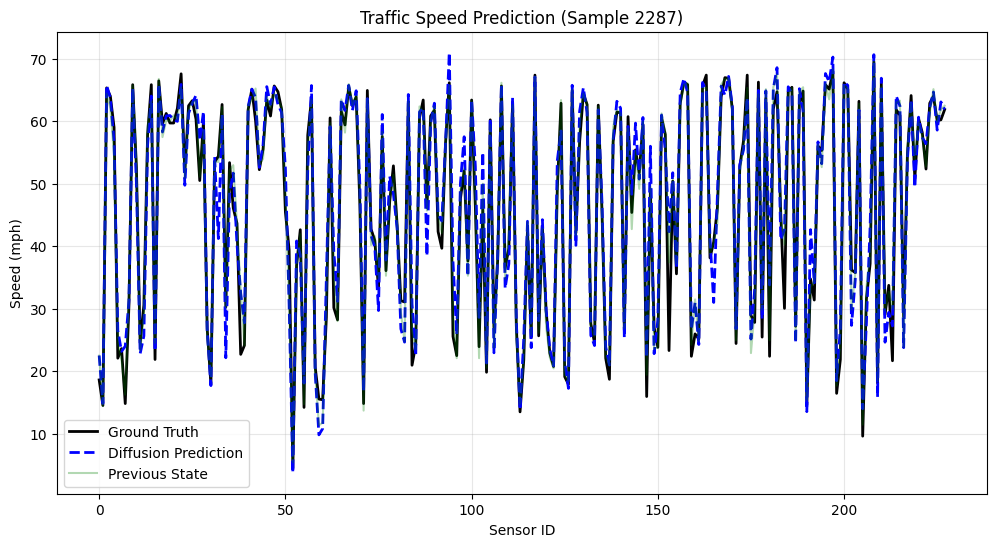

In [28]:
# --- CELL 3: TRAFFIC EVALUATION (Corrected for Z-Score) ---
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

TEST_DATA_PATH = "traffic_data/test_traffic.npy"
STATS_PATH = "traffic_data/stats.npy" # Load statistics
MODEL_PATH = f"{CHECKPOINT_DIR}/traffic_model.pth"
SENSOR_COUNT = 228
PAD_SIZE = 256
TIMESTEPS = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Stats
stats = np.load(STATS_PATH)
MEAN, STD = stats[0], stats[1]
print(f"📊 Stats Loaded. Mean: {MEAN:.2f}, Std: {STD:.2f}")

# Load Data
test_numpy = np.load(TEST_DATA_PATH)
N_test, T_test, S_test = test_numpy.shape
X_raw = torch.FloatTensor(test_numpy[:, :-1, :])
Y_raw = torch.FloatTensor(test_numpy[:, 1:, :])

X_pad = F.pad(X_raw, (0, PAD_SIZE - SENSOR_COUNT)).reshape(-1, 1, PAD_SIZE)
Y_pad = F.pad(Y_raw, (0, PAD_SIZE - SENSOR_COUNT)).reshape(-1, 1, PAD_SIZE)

# Load Model
model = ConditionalUNet1D().to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# Sample
@torch.no_grad()
def predict_traffic(condition, steps=300):
    x = torch.randn_like(condition).to(device)
    for i in reversed(range(steps)):
        t = (torch.ones(condition.shape[0]) * i).long().to(device)
        predicted_noise = model(x, t, condition)

        alpha_t = alpha[t][:, None, None]
        alpha_hat_t = alpha_hat[t][:, None, None]
        beta_t = beta[t][:, None, None]

        if i > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / (torch.sqrt(1 - alpha_hat_t))) * predicted_noise) + torch.sqrt(beta_t) * noise
    return x

test_idx = np.random.randint(0, len(X_pad))
input_cond = X_pad[test_idx].unsqueeze(0).to(device)
ground_truth = Y_pad[test_idx].unsqueeze(0).to(device)

print(f"🔮 Predicting Traffic (Sample {test_idx})...")
predicted_pad = predict_traffic(input_cond, steps=TIMESTEPS)

# Denormalize (Z-Score Reverse)
# x = (x_norm * std) + mean
pred_real = (predicted_pad[..., :SENSOR_COUNT].cpu().numpy().squeeze() * STD) + MEAN
truth_real = (ground_truth[..., :SENSOR_COUNT].cpu().numpy().squeeze() * STD) + MEAN
input_real = (input_cond[..., :SENSOR_COUNT].cpu().numpy().squeeze() * STD) + MEAN

# Plot
plt.figure(figsize=(12, 6))
x_axis = np.arange(SENSOR_COUNT)
plt.plot(x_axis, truth_real, color='black', linewidth=2, label='Ground Truth')
plt.plot(x_axis, pred_real, color='blue', linestyle='--', linewidth=2, label='Diffusion Prediction')
plt.plot(x_axis, input_real, color='green', alpha=0.3, label='Previous State')
plt.title(f"Traffic Speed Prediction (Sample {test_idx})")
plt.xlabel("Sensor ID")
plt.ylabel("Speed (mph)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

🎥 Simulating 1 hour of traffic (Sample 3330)...


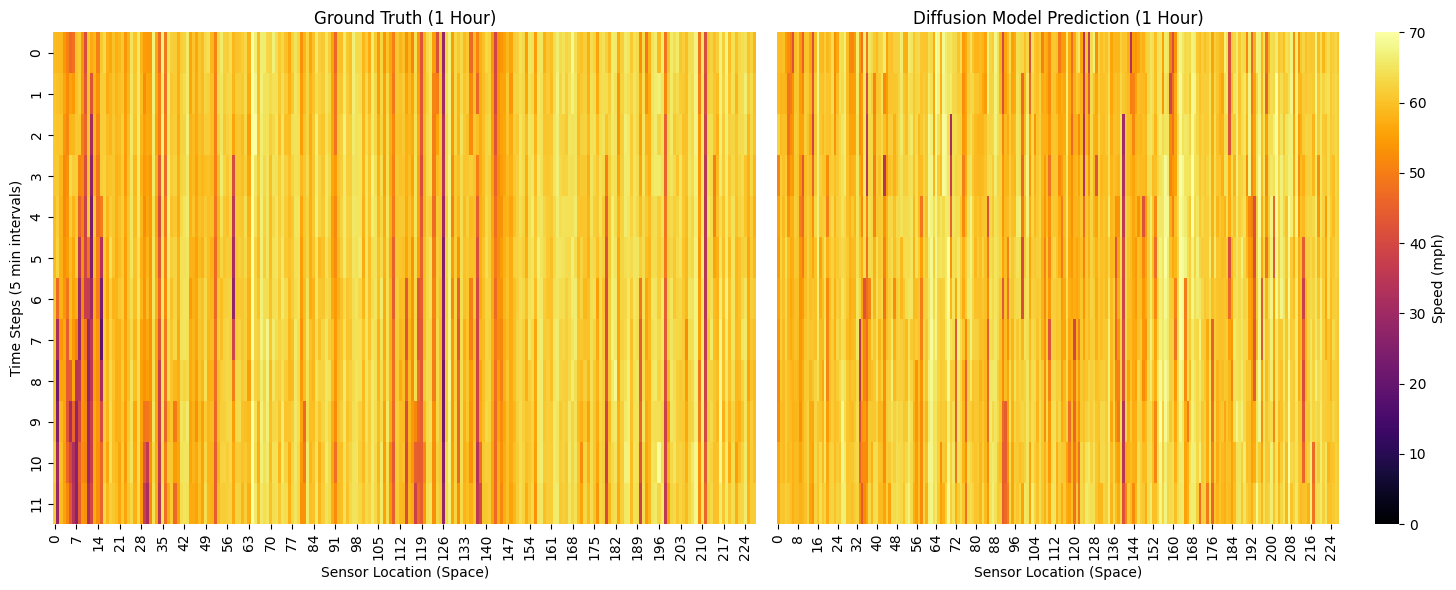

In [29]:
# --- CELL 4: ADVANCED VISUALIZATION (Space-Time Heatmap) ---
import matplotlib.pyplot as plt
import seaborn as sns

# CONFIGURATION
# We want to see a sequence of 12 steps (1 hour of traffic)
SEQ_LEN = 12
START_IDX = np.random.randint(0, len(X_pad) - SEQ_LEN)

print(f"🎥 Simulating 1 hour of traffic (Sample {START_IDX})...")

# 1. COLLECT TRUTH & PREDICTIONS
ground_truth_seq = []
prediction_seq = []

# We run autoregressive generation (feed prediction back as input)
current_input = X_pad[START_IDX].unsqueeze(0).to(device) # Initial state

for t in range(SEQ_LEN):
    # Get Truth (for plotting)
    truth_t = Y_pad[START_IDX + t].cpu().numpy().squeeze()[:SENSOR_COUNT]
    ground_truth_seq.append(truth_t)

    # Predict Next Step
    with torch.no_grad():
        pred_pad = predict_traffic(current_input, steps=100) # Faster steps for plotting

    # Store Prediction (Crop padding)
    pred_real = pred_pad[..., :SENSOR_COUNT].cpu().numpy().squeeze()
    prediction_seq.append(pred_real)

    # Update Input for next step (Autoregressive)
    current_input = pred_pad # Use our own prediction as next input

# 2. DENORMALIZE
# Using your stats (Mean/Std) to get mph
# shape: (12, 228)
truth_img = (np.array(ground_truth_seq) * STD) + MEAN
pred_img = (np.array(prediction_seq) * STD) + MEAN

# 3. PLOT HEATMAPS
plt.figure(figsize=(15, 6))

# Plot Ground Truth
plt.subplot(1, 2, 1)
sns.heatmap(truth_img, cmap="inferno", vmin=0, vmax=70, cbar=False)
plt.title("Ground Truth (1 Hour)")
plt.xlabel("Sensor Location (Space)")
plt.ylabel("Time Steps (5 min intervals)")

# Plot Prediction
plt.subplot(1, 2, 2)
sns.heatmap(pred_img, cmap="inferno", vmin=0, vmax=70, cbar_kws={'label': 'Speed (mph)'})
plt.title("Diffusion Model Prediction (1 Hour)")
plt.xlabel("Sensor Location (Space)")
plt.yticks([]) # Hide y-axis for cleaner look

plt.tight_layout()
plt.savefig("fig2_heatmap.png", dpi=300)
plt.show()

📊 Calculating aggregate error statistics...


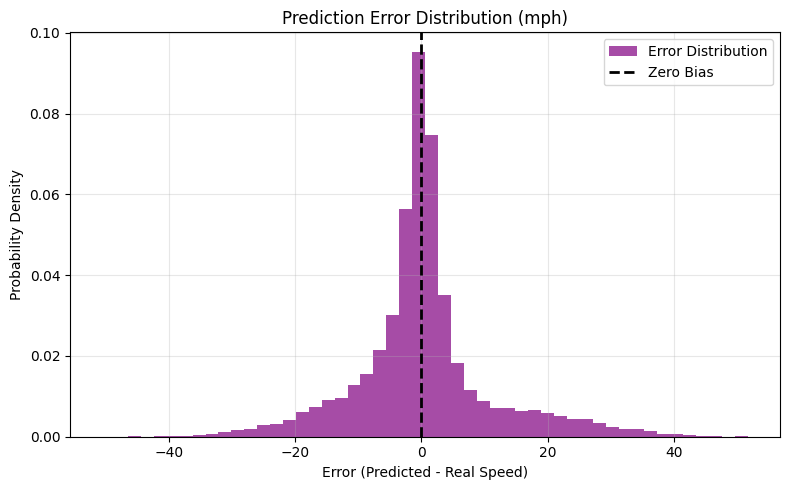

✅ FINAL TABLE 1 METRICS:
   MAE  (Mean Absolute Error): 7.07 mph
   RMSE (Root Mean Sq Error):  10.87 mph


In [31]:
# --- CELL 5: FINAL METRICS & ERROR HISTOGRAM ---
import matplotlib.pyplot as plt
import numpy as np

# Calculate errors for a batch of 100 samples
print("📊 Calculating aggregate error statistics...")
errors = []

indices = np.random.choice(len(X_pad), 100, replace=False)

for idx in indices:
    inp = X_pad[idx].unsqueeze(0).to(device)
    truth = Y_pad[idx][..., :SENSOR_COUNT].cpu().numpy().squeeze()

    # Fast inference (50 steps) just for stats
    pred = predict_traffic(inp, steps=50)[..., :SENSOR_COUNT].cpu().numpy().squeeze()

    # Denormalize
    truth_mph = (truth * STD) + MEAN
    pred_mph = (pred * STD) + MEAN

    # Error
    diff = pred_mph - truth_mph
    errors.extend(diff.flatten())

# Plot Histogram
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color='purple', alpha=0.7, density=True, label='Error Distribution')
plt.axvline(0, color='black', linestyle='--', linewidth=2, label='Zero Bias')
plt.title("Prediction Error Distribution (mph)")
plt.xlabel("Error (Predicted - Real Speed)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig("fig3_error_dist.png", dpi=300)
plt.show()

# Print Final Numbers for Table 1
errors = np.array(errors)
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))
print("="*30)
print(f"✅ FINAL TABLE 1 METRICS:")
print(f"   MAE  (Mean Absolute Error): {mae:.2f} mph")
print(f"   RMSE (Root Mean Sq Error):  {rmse:.2f} mph")
print("="*30)